In [4]:
import numpy as np
from qutip import *
import dask
from dask import delayed
import dask.bag as db
from dask.distributed import Client, LocalCluster,progress
from tqdm import tqdm
import pandas as pd
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
# figure_features()

In [42]:
def eigensystem_fbq_odd(Ec,El,Ej,e_S0,phi_ext, N = 100, eigvals = 0):
    # EIGENVALUES AND EIGENSTATES OF THE FERMIONIC-BOSONIC QUBIT 

    phi_ZPF=(8.0 * Ec / El) ** 0.25
    N_op  = 1j * (destroy(N).dag() - destroy(N)) / phi_ZPF /np.sqrt(2)
    phi_op= (destroy(N).dag() + destroy(N)) * phi_ZPF/ np.sqrt(2)
    delta = phi_op - phi_ext

    e_x = e_SO[0]
    e_y = e_SO[1]
    e_z = e_SO[2]

    H = 4*Ec*tensor(N_op**2,qeye(2)) + 0.5*El*tensor((delta)**2,qeye(2)) + Ej*tensor(phi_op.cosm(),qeye(2)) + e_x*tensor(phi_op.sinm(),sigmax()) + e_y*tensor(phi_op.sinm(),sigmay()) + e_z*tensor(phi_op.sinm(),sigmaz())
    evals,ekets=H.eigenstates(eigvals=eigvals)
    return evals,ekets

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]

In [102]:
# create a matrix of dimension N x N with a value -1 in the second diagonal and 1 in the minus first diagonal and 0 elsewhere and obtained not as a np.array
def sinphi_op(N):
    return Qobj(np.diag(np.ones(N-1),-1) - np.diag(np.ones(N-1),1))/2/1j

def cosphi_op(phi_ext,N):
    return Qobj(np.diag(np.ones(N-1),-1) + np.diag(np.ones(N-1),1))*np.exp(-1j*phi_ext)/2

In [88]:
def eigensystem_gatemon_odd(Ec,Eo,Ej,e_S0,phi_ext, N = 5, eigvals = 0):
    # EIGENVALUES AND EIGENSTATES OF THE FERMIONIC-BOSONIC QUBIT 
    ng = 0
    phi_op= (destroy(N).dag() + destroy(N)) * phi_ZPF/ np.sqrt(2)
    # delta = phi_op - phi_ext

    e_x = e_SO[0]
    e_y = e_SO[1]
    e_z = e_SO[2]

    H = 4*Ec*tensor((charge(N,-N) - ng*qeye(2*N + 1))**2, qeye(2)) + 0.5*Ej*tensor(qeye(2*N + 1) - cosphi_op(phi_ext,N),qeye(2)) + Eo*tensor(-tunneling(2*N + 1,1)/2,qeye(2)) - e_z*tensor(sinphi_op(N),sigmaz())
    
    evals,ekets=H.eigenstates(eigvals=eigvals)
    return evals,ekets

In [89]:
# plot the eigenvalues  of the function above
e_SO = [0,0,0.56e9]
Eo = 0.11e9
Ej = 12.5e9
Ec = 0.284e9
eigvals = 6

phi_ext_list = np.linspace(0,2*np.pi,50)
evals_list = np.zeros((len(phi_ext_list),eigvals))
for i, phi_ext in enumerate(tqdm(phi_ext_list)):
    evals,ekets = eigensystem_fbq_odd(Ec,El,Ej,e_SO,phi_ext, N = 100, eigvals = eigvals)
    evals_list[i,:] = evals 

phi_ext_list = np.concatenate([-phi_ext_list[::-1][0:-1],phi_ext_list])
evals_list = np.concatenate([evals_list[::-1][0:-1],evals_list])


100%|██████████| 50/50 [00:03<00:00, 12.59it/s]


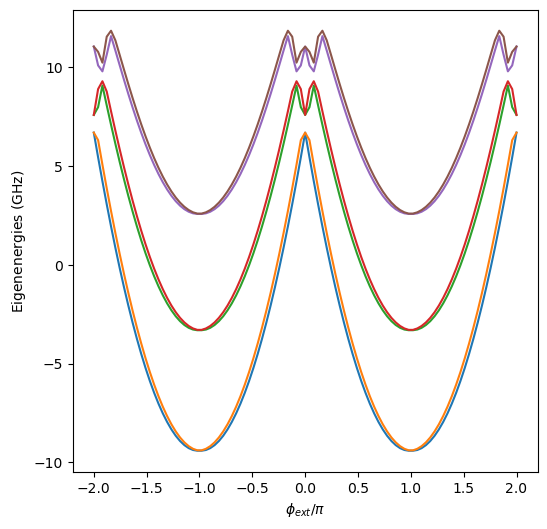

In [90]:
fig,ax = plt.subplots(figsize=(6,6))
# for i in range(eigvals):
#     ax.plot(phi_ext_list/np.pi,evals_list[:,i]/1e9)

ax.plot(phi_ext_list/np.pi,(evals_list[:,:])/1e9)
ax.set_xlabel(r'$\phi_{ext}/\pi$')
ax.set_ylabel(r'Eigenenergies $\mathrm{(GHz)}$')

plt.show()